In [1]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.integrate import quad


In [2]:
# Parameters
n = 30
C = 4
meanT = 40
meanM = 15
meanM = meanM - 1
VarM = meanM**2
oneItemST = 3

# Parameters of the LOGNORMAL distribution
mu = math.log(meanM**2/math.sqrt(VarM+meanM**2))
sigma = math.sqrt(math.log((VarM/meanM**2)+1))

# The number of items in a customer's cart is a LOGNORMAL random variable
def lognormCDF(x_, mu_, sigma_):
    return lognorm.cdf(x_, s=sigma_, scale=math.exp(mu_))

def lognormPDF(x_, mu_, sigma_):
    return lognorm.pdf(x_, s=sigma_, scale=math.exp(mu_))

# Factors
p = 0.5
K = 8

# CSV name
csv_name = "VTM_Lognormal_New"

In [3]:
print("mu = ", mu)
print("sigma = ", sigma)

mu =  2.292483739335286
sigma =  0.8325546111576977


In [4]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "scalar"], CSV[CSV["type"] == "vector"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

In [5]:

CSV_Vector = CSV[CSV["type"] == "vector"]

# W: Mean Waiting Time [Queues]
Exp_W = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.checkout.queues")]
Exp_W = Exp_W[Exp_W["name"] == "queueingTime:vector"]

# NQ: Mean Number of Customers in Queue [Queues]
Exp_NQ_Vector = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.checkout.queues")]
Exp_NQ_Vector = Exp_NQ_Vector[Exp_NQ_Vector["name"] == "queueLength:vector"]

CSV_Scalar = CSV[CSV["type"] == "scalar"]

# NQ: Mean Number of Customers in Queue [Queues]
Exp_NQ = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_NQ = Exp_NQ[Exp_NQ["name"] == "queueLength:timeavg"]

# RHO: Mean Utilization [Queues]
Exp_RHO = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.queues")]
Exp_RHO = Exp_RHO[Exp_RHO["name"] == "busy:timeavg"]

# S: Mean Service Time (t_S) [LocalSink] 
Exp_S = CSV_Scalar[CSV_Scalar["module"].str.contains("SuperMarket.checkout.localSink")]
Exp_S = Exp_S[Exp_S["name"] == "totalServiceTime:mean"]

# Dictionary for containing all the DataFrames
CSV_Dict = {
    "W": Exp_W,
    "NQ_Vector": Exp_NQ_Vector,
    "NQ": Exp_NQ,
    "RHO": Exp_RHO,
    "S": Exp_S
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in Exp_W.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[2]] = "BASE"


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[2]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if key == "W" or key == "NQ_Vector":
                PI[key][config[run]][run][string] = row["vecvalue"]

            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if key == "TW":
                PI[key][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][config[run]][run] = float(row["value"])


# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



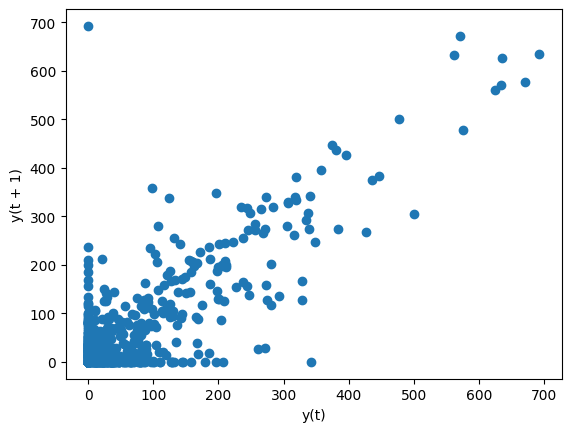

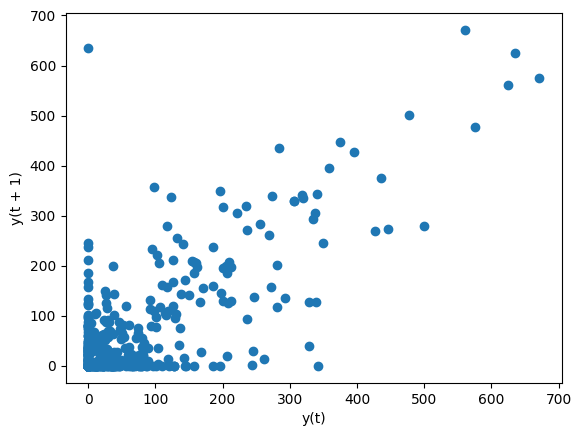

C:\Users\giova\AppData\Local\Temp\ipykernel_18156\2542735261.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(values, hist=False, rug=True)


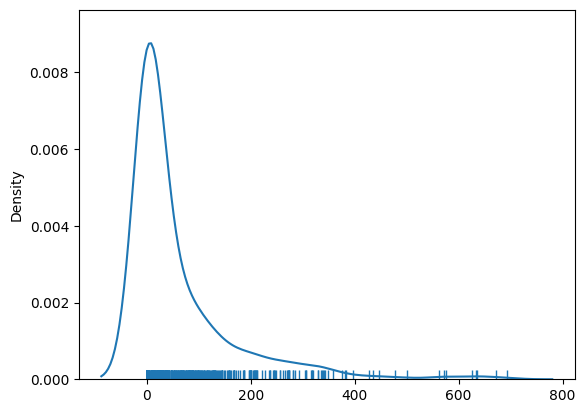

In [11]:
# from statsmodels.graphics.gofplots import qqplot
# from pandas.plotting import lag_plot

# values = PI_df["W"]["BASE"]["Q3"].iloc[13]
# values = values.split(" ")
# values = [float(i) for i in values]
# values = pd.DataFrame(values)
# lag_plot(values)
# plt.show()
# subsample = values.sample(frac=0.7)
# subsample.sort_index(inplace=True)
# lag_plot(subsample)
# plt.show()
# sns.distplot(values, hist=False, rug=True)
# plt.show()

In [12]:
# Subsampling and Mean Computation
for index, row in PI_df["W"]["BASE"].iterrows():
    for q in Q:
        values = row[q].split(" ")
        values = [float(v) for v in values]
        values = pd.DataFrame(values)
        subsample = values.sample(frac=0.7)
        PI_df["W"]["BASE"].loc[index, q] = subsample.mean()[0]

In [14]:
pi = "W"
P_LOG = {}
P_LOG[pi] = {}

P_LOG[pi]["BASE"] = pd.DataFrame(columns=Q)
for q in Q:
    P_LOG[pi]["BASE"][q] = np.log(PI_df[pi]["BASE"][q].values.astype(np.float64).tolist())


In [15]:
P_LOG["W"]["BASE"]

,Q0,Q1,Q2,Q3
0,0.208025,-0.511892,3.884440,3.486029
1,-0.287587,-0.452452,3.887166,3.956468
2,-0.492588,-0.643754,3.421974,3.909526
3,-0.895794,-0.720149,3.502309,3.703056
4,-0.168573,-0.317893,4.045037,3.881498
5,-0.231056,0.011039,4.160294,3.773253
6,-0.362350,-0.329154,3.632469,3.483712
7,-0.766077,-0.008578,3.878563,4.046762
8,-0.407262,-0.418460,3.599156,3.905188
9,-0.132782,-0.874271,4.106911,3.740408


In [18]:
PI_TABLE = {}


for key in PI_df:
    if key == "NQ_Vector":
        continue
    PI_TABLE[key] = pd.DataFrame(columns=["Theoretical", "Mean", "CI - LB", "CI - UB"])
    
    # Mean Value of the "n" repetitions for each Queue
    PI_TABLE[key]["Mean"] = PI_df[key]["BASE"].mean()

    if key == "W":
        # CI 95% (Cox Method)
        # Lower Bound
        PI_TABLE[key]["CI - LB"] = np.exp(P_LOG[key]["BASE"].mean() + (P_LOG[key]["BASE"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[key]["BASE"].std()**2 / n) + (P_LOG[key]["BASE"].std()**4 / (2 * (n-1))))))
        # Upper Bound
        PI_TABLE[key]["CI - UB"] = np.exp(P_LOG[key]["BASE"].mean() + (P_LOG[key]["BASE"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[key]["BASE"].std()**2 / n) + (P_LOG[key]["BASE"].std()**4 / (2 * (n-1))))))

    else:
        # CI 95% (Normal)
        # Lower Bound
        PI_TABLE[key]["CI - LB"] = PI_df[key]["BASE"].mean() - (1.96 * (PI_df[key]["BASE"].std() / math.sqrt(n)))
        # Upper Bound
        PI_TABLE[key]["CI - UB"] = PI_df[key]["BASE"].mean() + (1.96 * (PI_df[key]["BASE"].std() / math.sqrt(n)))



In [17]:
for key in PI_TABLE:
    print(f"[{key}]:")
    print(PI_TABLE[key])
    print("\n")

[W]:
   Theoretical       Mean    CI - LB    CI - UB
Q0         NaN   0.802983   0.725393   0.891695
Q1         NaN   0.788791   0.718848   0.869397
Q2         NaN  43.378735  39.780986  47.346844
Q3         NaN  45.722288  42.696147  49.034860


[NQ]:
   Theoretical      Mean   CI - LB   CI - UB
Q0         NaN  0.003838  0.003404  0.004271
Q1         NaN  0.003812  0.003512  0.004112
Q2         NaN  0.344048  0.311578  0.376518
Q3         NaN  0.358798   0.33471  0.382886


[RHO]:
   Theoretical      Mean   CI - LB   CI - UB
Q0         NaN  0.078654  0.077059  0.080249
Q1         NaN  0.078522  0.076994   0.08005
Q2         NaN  0.480816  0.473381  0.488252
Q3         NaN  0.486472  0.478377  0.494567


[S]:
   Theoretical       Mean    CI - LB    CI - UB
Q0         NaN  16.764889  16.668415  16.861364
Q1         NaN  16.833326  16.746425  16.920226
Q2         NaN  61.435091  60.817201  62.052981
Q3         NaN  61.817371  61.173318  62.461425




In [19]:
# Theoretical Formulas and Computations

# g(M) = round(M) + 1 = floor(M+1.5)
def g(x):
    return math.floor(x+1.5)  

def integrand(x):
    return (g(x) * lognormPDF(x, mu, sigma))

def integrand_2(x):
    return ((g(x)**2) * lognormPDF(x, mu, sigma))



# Number of Quick Tills
quickTills = int(p*C)

# Interarrival Rate
lambdaT = 1/meanT

temp = {}

if (quickTills == 0) or quickTills == C:
    # There are no Quick Tills or all the Tills are Quick Tills
    # So the probability alphaK of being routed to a Quick Till is either 0 or 1

    pi_ = 1/C
    lambdaT_ = lambdaT*pi_

    meanST_ = meanM * oneItemST
    lambdaST_ = 1/meanST_
    
    # Utilization
    rho_ = lambdaT_/lambdaST_

    # Mean Number of Customers in M/M/1
    N_ = rho_/(1-rho_)

    # Mean Number of Customers in a Queue
    NQ_ = N_ - rho_

    # Mean Response Time
    R_ = N_/lambdaT_

    # Mean Waiting Time
    W_ = R_ - meanST_


    temp["NQ"] = NQ_
    temp["RHO"] = rho_
    temp["S"] = meanST_
    temp["W"] = W_


    for key in PI_TABLE:
        PI_TABLE[key]["Theoretical"] = [temp[key]] * C

else:
    # There are Quick Tills AND Normal Tills
    # So the probability alphaK of being routed to a Quick Till is 0 < alphaK < 1
    
    # CDF of an EXPONENTIAL distribution
    alphaK = lognormCDF((K-0.5), mu, sigma)

    # --- Quick Tills ---

    # Probability of being routed to a specific Quick Till (i)
    # Inside a subsystem (Quick Tills or Normal Tills) the
    # probability of being routed to a specific Till is the
    # same (i.e. "equallylikely")
    pi_i = alphaK/quickTills
    
    # Interarrival Rate for an individual Quick Till
    lambdaT_i = lambdaT*pi_i
    
    # Mean Number of items in a customer's cart for an individual Quick Till
    meanM_i = (quad(integrand, 0, (K-0.5), limit=200)[0])/alphaK

    # Mean Service Time for an individual Quick Till
    meanST_i = meanM_i * oneItemST


    # Variance = E[X^2] - E[X]^2
    # Variance of M_i
    VarM_i = ((quad(integrand_2, 0, (K-0.5), limit=200)[0])/alphaK) - meanM_i**2

    # Variance of ST_i
    VarST_i = VarM_i * oneItemST**2
    
    
    # Performance Indeces for an individual Quick Till

    rho_i = lambdaT_i * meanST_i
    N_i = rho_i + ((rho_i**2 + lambdaT_i**2 * VarST_i)/(2*(1-rho_i)))
    NQ_i = N_i - rho_i
    R_i = N_i/lambdaT_i
    W_i = R_i - meanST_i
    
    temp["NQ"] = {}
    temp["NQ"]["i"] = NQ_i

    temp["RHO"] = {}
    temp["RHO"]["i"] = rho_i

    temp["S"] = {}
    temp["S"]["i"] = meanST_i

    temp["W"] = {}
    temp["W"]["i"] = W_i


    # --- Normal Tills ---

    # Probability of being routed to a specific Normal Till (j)
    # Inside a subsystem (Quick Tills or Normal Tills) the
    # probability of being routed to a specific Till is the
    # same (i.e. "equallylikely")
    pi_j = (1-alphaK)/(C-quickTills)

    # Interarrival Rate for an individual Normal Till
    lambdaT_j = lambdaT*pi_j

    # Mean Number of items in a customer's cart for an individual Normal Till
    meanM_j = (quad(integrand, (K-0.5), np.inf, limit=200)[0])/(1-alphaK)

    # Mean Service Time for an individual Normal Till
    meanST_j = meanM_j * oneItemST

    # Variance = E[X^2] - E[X]^2
    # Variance of M_j
    VarM_j = ((quad(integrand_2, (K-0.5), np.inf, limit=200)[0])/(1-alphaK)) - meanM_j**2

    # Variance of ST_j
    VarST_j = VarM_j * oneItemST**2
    
    # Performance Indeces for an individual Normal Till

    rho_j = lambdaT_j * meanST_j
    N_j = rho_j + ((rho_j**2 + lambdaT_j**2 * VarST_j)/(2*(1-rho_j)))
    NQ_j = N_j - rho_j
    R_j = N_j/lambdaT_j
    W_j = R_j - meanST_j

    temp["NQ"]["j"] = NQ_j
    temp["RHO"]["j"] = rho_j
    temp["S"]["j"] = meanST_j
    temp["W"]["j"] = W_j
    
    # Adding the Theoretical Values to the PI_TABLE
    for key in PI_TABLE:
        PI_TABLE[key]["Theoretical"] = [temp[key]["i"]] * quickTills + [temp[key]["j"]] * (C-quickTills)

    


C:\Users\giova\AppData\Local\Temp\ipykernel_18156\1932056582.py:124: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  meanM_j = (quad(integrand, (K-0.5), np.inf, limit=200)[0])/(1-alphaK)
C:\Users\giova\AppData\Local\Temp\ipykernel_18156\1932056582.py:131: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from sp

In [20]:
for key in PI_TABLE:
    PI_TABLE[key]["OK"] = [""] * C
    for i in range(C):
        if PI_TABLE[key]["Theoretical"].iloc[i] <= PI_TABLE[key]["CI - UB"].iloc[i] and PI_TABLE[key]["Theoretical"].iloc[i] >= PI_TABLE[key]["CI - LB"].iloc[i]:
            PI_TABLE[key].loc[f"Q{i}", "OK"] = "V"

In [21]:
for key in PI_TABLE:
    print(f"[{key}]:")
    print(PI_TABLE[key])
    print("\n")

[W]:
    Theoretical       Mean    CI - LB    CI - UB OK
Q0     0.772947   0.802983   0.725393   0.891695  V
Q1     0.772947   0.788791   0.718848   0.869397  V
Q2    44.596290  43.378735  39.780986  47.346844  V
Q3    44.596290  45.722288  42.696147  49.034860  V


[NQ]:
    Theoretical      Mean   CI - LB   CI - UB OK
Q0     0.003569  0.003838  0.003404  0.004271  V
Q1     0.003569  0.003812  0.003512  0.004112  V
Q2     0.351523  0.344048  0.311578  0.376518  V
Q3     0.351523  0.358798   0.33471  0.382886  V


[RHO]:
    Theoretical      Mean   CI - LB   CI - UB OK
Q0     0.077617  0.078654  0.077059  0.080249  V
Q1     0.077617  0.078522  0.076994   0.08005  V
Q2     0.484940  0.480816  0.473381  0.488252  V
Q3     0.484940  0.486472  0.478377  0.494567  V


[S]:
    Theoretical       Mean    CI - LB    CI - UB OK
Q0    16.808667  16.764889  16.668415  16.861364  V
Q1    16.808667  16.833326  16.746425  16.920226  V
Q2    61.522346  61.435091  60.817201  62.052981  V
Q3    61.5223

In [10]:
# alphaK is in the denominator because
# it is there to normalize the PDF. Indeed
# calculating the integral of the truncated
# PDF from 0 to K-0.5 gives exactly 1

def integrand_Test(x):
    return lognormPDF(x, mu, sigma)

meanM_i = (quad(integrand_Test, 0, (K-0.5), limit=200)[0])/alphaK
meanM_i

0.9999999999998394

In [11]:
def integrand_Test(x):
    return (math.floor(x+1+0.5)*lognormPDF(x, mu, sigma))

print("Mean(M'') (with Mean(M) = m-1): " + str(quad(integrand_Test, 0, np.inf, limit=200)[0]))


Mean(M'') (with Mean(M) = m-1): 15.000453066265877


C:\Users\giova\AppData\Local\Temp\ipykernel_16196\41242726.py:4: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print("Mean(M'') (with Mean(M) = m-1): " + str(quad(integrand_Test, 0, np.inf, limit=200)[0]))
